In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import yaml
import pprint
import os
import time
import numpy as np
# weights and biases for tracking of metrics
import wandb 
# make the plots inline again
%matplotlib inline
# sometimes have to activate this to plot plots in notebook
# matplotlib.use('Qt5Agg')
from code import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def log_surface_hypersphere(n_dim_sphere, r=1):
    """
    n_dim_sphere of the sphere embedded in the n+1 dimensional Euclidean space
    
    Calculate surface in log space for numerical stability. Work with log gamma function for numerical stability.
    """
    
    s1 = (n_dim_sphere + 1) / 2 * torch.log(torch.tensor(math.pi)) + torch.log(torch.tensor(2.))
    
    s2 = - torch.lgamma( torch.tensor(n_dim_sphere + 1, dtype=torch.float32) / 2)

    s3 = n_dim_sphere * torch.log(torch.tensor(r).float())

    return s1 + s2 + s3



In [4]:

# save statements are commented out currently

def get_log_f_s(A, s):
    """Calculate  -log f(s) with s ~ q"""
    
    dim = A.shape[0]
    s = s.unsqueeze(-1)

    return - dim * torch.log(torch.norm(torch.matmul(A, s).squeeze(-1), dim=1))
    

def get_mean_neg_ELBO(ldj, log_f_s, log_surface):
    """Calculate KL divergence according to 22.1"""    
    return torch.mean( - ldj - log_f_s)


def train_model(model, optimizer, A, model_name, max_iter = int(1e3), ELBO_list=None, dj_list=None):

    path = 'det_estimate_model/10D'
    os.makedirs(path, exist_ok=True)
    
    A = A.to(device)
    dim = A.shape[0]
    
    if ELBO_list is None and dj_list is None:
        ELBO_list = []
        dj_list = []
    elif ELBO_list is not None and dj_list is not None:
        ELBO_list = list(ELBO_list)
        dj_list = list(dj_list)
    else:
        raise Exception('Elbo list and dj list have to be both none or not none')
        
        
    log_surface = log_surface_hypersphere(n_dim_sphere = A.shape[0] - 1, r = 1)

    for iter_ in range(len(ELBO_list), max_iter):

        s_0 = torch.randn(BATCH_SIZE, dim).to(device)
        s_0 = s_0 / torch.norm(s_0, dim = 1, keepdim=True) 
        s_0.requires_grad = True

        optimizer.zero_grad()

        s, ldj, _ = model(s_0)

        log_f_s = get_log_f_s(A, s)

        neg_ELBO = get_mean_neg_ELBO(ldj, log_f_s, log_surface)

        neg_ELBO.backward()
        optimizer.step()

        ELBO_list.append(neg_ELBO)

        if iter_ % 10 == 0:
            print(f'at iter {iter_} ELBO loss metric {neg_ELBO}')

        if iter_ % 50 == 0:    
            
            s_0 = torch.randn(int(1e5), dim).to(device)
            s_0 = s_0 / torch.norm(s_0, dim = 1, keepdim=True) 
            
            with torch.no_grad():
                
                _, ldj, _ = model(s_0)
                
            dj_list.append(ldj.exp().mean())

            print(f'\n ldj check {ldj.exp().mean()} \n')            

        # plot stuff
        if iter_ % 100 == 0 and iter_ != 0:
            print(f'Iter {iter_}')
            
            plt.plot(range(len(ELBO_list)), ELBO_list)        
            plt.show()
            plt.plot(range(len(dj_list)), dj_list)        
            plt.show()

        if iter_ % 200 == 0:
            
            print("\n ### SAVE MODEL ### \n")
            
            state = {
                'iter_': iter_,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }                        

#             torch.save(state, f"{path}/{model_name}.t7") 
            
            import numpy as np
            
#             np.save(f"{path}/ELBO_list_{model_name}.npy",np.array(ELBO_list))
#             np.save(f"{path}/dj_list_{model_name}.npy",np.array(dj_list))

        

### train model in 10D

In [5]:
for run in range(0,5):

    A = torch.randn(10,10)

    print(f'true abs determinant {torch.abs(torch.det(A)).cpu().numpy()}')
    print(f'true log determinant {torch.slogdet(A)[1].cpu().numpy()} \n')


    NUM_CENTERS = 12
    NUM_BINS = 16
    NUM_FLOWS_COU = 8
    NUM_DIM_DATA = A.shape[0]
    dim = NUM_DIM_DATA
    CAP_HOUSEHOLDER_REFL = False
    BATCH_SIZE = 1024

    np.save(f'det_estimate_model/10D/matrix_in_10d_{run}.npy',np.array(A.detach().cpu().numpy()))

    ### cou cylindrical moebius model
    cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                     num_bins=NUM_BINS, 
                                     flow_type='moebius',
                                     num_dim_data=NUM_DIM_DATA, 
                                     mask_type='coupling',
                                     num_centers=NUM_CENTERS)

    cyl_cou_moeb.to(device)

    optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())


    ### train cou cyl moeb
    max_iter = int(10e3)
    train_model(cyl_cou_moeb, optimizer_cyl_cou, A, model_name=f'cyl_moeb_{run}', max_iter = max_iter)

true abs determinant 346.52398681640625
true log determinant 5.847951889038086 

at iter 0 ELBO loss metric 9.89312744140625

 ldj check 0.9999533891677856 


 ### SAVE MODEL ### 

at iter 10 ELBO loss metric 9.831487655639648
at iter 20 ELBO loss metric 9.708919525146484


KeyboardInterrupt: 

### load trained model and continue training. e.g matrix with index 4

In [25]:
NUM_CENTERS = 12
NUM_BINS = 16
NUM_FLOWS_COU = 8
NUM_DIM_DATA = 10
dim = NUM_DIM_DATA
CAP_HOUSEHOLDER_REFL = False
BATCH_SIZE = 1024

In [29]:
### load cylindrical moebius model
cyl_cou_moeb = Cylindrical_Flow(num_flows=NUM_FLOWS_COU,
                                 num_bins=NUM_BINS, 
                                 flow_type='moebius',
                                 num_dim_data=NUM_DIM_DATA, 
                                 mask_type='coupling',
                                 add_phase_translation=False,
                                 num_centers=NUM_CENTERS)

cyl_cou_moeb.to(device)

optimizer_cyl_cou = optim.AdamW(cyl_cou_moeb.parameters())



state = torch.load('det_estimate_model/10D/cyl_moeb_4.t7')

cyl_cou_moeb.load_state_dict(state['state_dict'])
optimizer_cyl_cou.load_state_dict(state['optimizer'])

In [36]:
### load matrix, elbo and log det list
A = np.load('det_estimate_model/10D/matrix_in_10d_4.npy')
A = torch.tensor(A)

ELBO_list = np.load('det_estimate_model/10D/ELBO_list_cyl_moeb_4.npy',allow_pickle=True)
dj_list = np.load('det_estimate_model/10D/dj_list_cyl_moeb_4.npy',allow_pickle=True)


at iter 9810 ELBO loss metric 5.64968204498291
at iter 9820 ELBO loss metric 5.615593910217285
at iter 9830 ELBO loss metric 5.616179466247559
at iter 9840 ELBO loss metric 5.634521007537842
at iter 9850 ELBO loss metric 5.629029273986816

 ldj check 0.7671229243278503 

at iter 9860 ELBO loss metric 5.644814491271973
at iter 9870 ELBO loss metric 5.642635822296143
at iter 9880 ELBO loss metric 5.637880325317383
at iter 9890 ELBO loss metric 5.636361598968506
at iter 9900 ELBO loss metric 5.64169454574585

 ldj check 0.7810705304145813 

Iter 9900


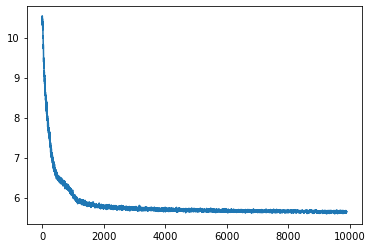

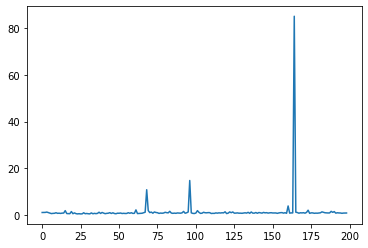

at iter 9910 ELBO loss metric 5.6458353996276855
at iter 9920 ELBO loss metric 5.650726318359375
at iter 9930 ELBO loss metric 5.647438049316406
at iter 9940 ELBO loss metric 5.668628692626953
at iter 9950 ELBO loss metric 5.668725967407227

 ldj check 0.759210467338562 

at iter 9960 ELBO loss metric 5.6353068351745605
at iter 9970 ELBO loss metric 5.6570892333984375
at iter 9980 ELBO loss metric 5.650771141052246
at iter 9990 ELBO loss metric 5.641919136047363


In [37]:
### continue training
max_iter = int(10e3)
train_model(cyl_cou_moeb, 
            optimizer_cyl_cou, 
            A, 
            model_name='cyl_cou_moeb_v5', 
            max_iter = max_iter,
            ELBO_list = ELBO_list,
            dj_list = dj_list)